# An Introductionto `xarray`

## Why do we need `xarray`?
As Geoscientists, we often work with time series of data with two or more dimensions: a time series of calibrated, orthorectified satellite images; two-dimensional grids of surface air temperature from an atmospheric reanalysis; or three-dimensional (level, x, y) cubes of ocean salinity from an ocean model.  These data are often provided in GeoTIFF, NetCDF or HDF format with rich and useful metadata that we want to retain, or even use in our analysis.  Common analyses include calculating means, standard deviations and anomalies over time or one or more spatial dimensions (e.g. zonal means).  Model output often includes multiple variables that you want to apply similar analyses to.

![A schematic of multi-dimensional data](data/dataset-diagram.png)

The schematic above shows a typical data structure for multi-dimensional data.  There are two data cubes, one for temperature and one for precipitation.  Common coordinate variables, in this case latitude, longitude and time are associated with each variable.  Each variable, including coordinate variables, will have a set of attributes: name, units, missing value, etc.  The file containing the data may also have attributes: source of the data, model name coordinate reference system if the data are projected.  Writing code using low-level packages such as `netcdf4` and `numpy` to read the data, then perform analysis, and write the results to file is time consuming and prone to errors.  

## What is `xarray`
`xarray` is an open-source project and `python` package to work with labelled multi-dimensional arrays.  It is leverages `numpy`, `pandas`, `matplotlib` and `dask` to build `Dataset` and `DataArray` objects with builtin methods to subset, analyze, interpolate, and plot multi-dimensional data.  It makes working with multi-dimensional data cubes efficient and fun.  __It will change your life for the better.  You'll be more attractive, more interesting, and better equiped to take on lifes challenges.__

## What you will learn from this tutorial
In this tutorial you will learn how to:
- load a netcdf file into `xarray`
- interrogate the Dataset and understand the difference between `DataArray` and `Dataset`
- subset a `Dataset`
- calculate annual and monthly mean fields
- calculate a time series of zonal means
- plot these results

As always, we'll start by importing `xarray`.  We'll follow convention by giving the module the shortname `xr`

In [67]:
import xarray as xr

xr.set_options(keep_attrs=True)

I'm going to use one of `xarray`'s tutorial datasets.  In this case, air temperature from the NCEP reanalysis.  I'll assign the result of the `open_dataset` to `ds`.  _I may change this to access a dataset directly_

In [68]:
ds = xr.tutorial.open_dataset("air_temperature")

As we are in an interactive environment, we can just type `ds` to see what we have.

In [69]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

First thing to notice is that `ds` is an `xarray.Dataset` object.  It has dimensions, `lat`, `lon`, and `time`.  It also has coordinate variables with the same names as these dimensions.  These coordinate variables are 1-dimensional.  This is a NetCDF convention.  The Dataset contains one data variable, `air`.  This has dimensions `(time, lat, lon)`.

Clicking on the document icon reveals attributes for each variable.  Clicking on the disk icon reveals a representation of the data.

Each of the data and coordinate variables can be accessed and examined using the variable name as a key. 

In [70]:
ds['air']

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

These are `xarray.DataArray` objects.  This is the basic building block for `xarray`.  

Variables can also be accessed as attributes of `ds`.

In [71]:
ds.time

<xarray.DataArray 'time' (time: 2920)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T06:00:00.000000000',
       '2013-01-01T12:00:00.000000000', ..., '2014-12-31T06:00:00.000000000',
       '2014-12-31T12:00:00.000000000', '2014-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

A major difference between accessing a variable as an attribute versus using a key is that the attribute is read-only but the key method can be used to update the variable.  For example, if I want to convert the units of `air` from Kelvin to degrees Celsius. 

In [72]:
ds['air'] = ds.air - 273.15

This approach can also be used to add new variables

In [73]:
ds['air_kelvin'] = ds.air + 273.15

In [74]:
ds

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat         (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon         (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time        (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air         (time, lat, lon) float32 -31.95 -30.65 -29.65 ... 23.04 22.54
    air_kelvin  (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Subsetting and Indexing

Subsetting and indexing methods depend on whether you are working with a `Dataset` or `DataArray`.  A `DataArray` can be accessed using positional indexing just like a `numpy` array.  To access the temperature field for the first time step, you do the following. 

In [75]:
ds.air[0,:,:]

<xarray.DataArray 'air' (lat: 25, lon: 53)>
array([[-31.949997, -30.649994, -29.649994, ..., -40.350006, -37.649994,
        -34.550003],
       [-29.350006, -28.649994, -28.449997, ..., -40.350006, -37.850006,
        -33.850006],
       [-23.149994, -23.350006, -24.259995, ..., -39.949997, -36.759995,
        -31.449997],
       ...,
       [ 23.450012,  23.049988,  23.25    , ...,  22.25    ,  21.950012,
         21.549988],
       [ 22.75    ,  23.049988,  23.640015, ...,  22.75    ,  22.75    ,
         22.049988],
       [ 23.140015,  23.640015,  23.950012, ...,  23.75    ,  23.640015,
         23.450012]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Note this returns a `DataArray` with coordinates but not attributes.

However, the real power is being able to access variables using coordinate variables.  I can get the same subset using the following.

In [76]:
ds.air.sel(time='2013-01-01')

<xarray.DataArray 'air' (time: 4, lat: 25, lon: 53)>
array([[[-31.949997, -30.649994, -29.649994, ..., -40.350006,
         -37.649994, -34.550003],
        [-29.350006, -28.649994, -28.449997, ..., -40.350006,
         -37.850006, -33.850006],
        [-23.149994, -23.350006, -24.259995, ..., -39.949997,
         -36.759995, -31.449997],
        ...,
        [ 23.450012,  23.049988,  23.25    , ...,  22.25    ,
          21.950012,  21.549988],
        [ 22.75    ,  23.049988,  23.640015, ...,  22.75    ,
          22.75    ,  22.049988],
        [ 23.140015,  23.640015,  23.950012, ...,  23.75    ,
          23.640015,  23.450012]],

       [[-31.050003, -30.449997, -30.050003, ..., -41.149994,
         -39.550003, -37.350006],
        [-29.550003, -29.050003, -28.949997, ..., -42.149994,
         -40.649994, -37.449997],
        [-19.949997, -20.259995, -21.050003, ..., -42.350006,
         -39.759995, -34.649994],
...
        [ 22.450012,  22.25    ,  22.25    , ...,  23.140015,
          22.140015,  21.850006],
        [ 23.049988,  23.350006,  23.140015, ...,  23.25    ,
          22.850006,  22.450012],
        [ 23.25    ,  23.140015,  23.25    , ...,  23.850006,
          23.850006,  23.640015]],

       [[-31.259995, -31.350006, -31.350006, ..., -38.759995,
         -37.649994, -35.550003],
        [-26.850006, -27.850006, -28.949997, ..., -42.259995,
         -41.649994, -38.649994],
        [-16.549988, -18.449997, -21.050003, ..., -42.449997,
         -41.350006, -37.050003],
        ...,
        [ 23.450012,  23.25    ,  22.850006, ...,  23.350006,
          22.640015,  22.140015],
        [ 23.850006,  24.350006,  23.950012, ...,  23.640015,
          23.450012,  23.140015],
        [ 24.350006,  24.549988,  24.350006, ...,  24.640015,
          24.850006,  24.75    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-01T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

I can also do slices.  I'll extract temperatures for the state of Colorado.  The bounding box for the state is [-109 E, -102 E, 37 N, 41 N].  

Pay attention to both the order of the coordinates and the range of values.  The first value of the `lat` coordinate variable is 75 N, the last value is 15 N.  Unfortunately, `xarray` expects slices of coordinates to be in the same order as the coordinates.  Note `lon` is 0 to 360 not -180 to 180.    

In [77]:
ds.air.sel(lat=slice(41.,37.), lon=slice(360-109,360-102))

<xarray.DataArray 'air' (time: 2920, lat: 2, lon: 3)>
array([[[-10.049988 ,  -9.25     ,  -8.75     ],
        [ -6.25     ,  -6.549988 ,  -6.3599854]],

       [[-18.149994 , -14.950012 ,  -9.950012 ],
        [-13.649994 , -11.049988 ,  -7.25     ]],

       [[-20.449997 , -18.649994 , -13.359985 ],
        [-19.350006 , -16.950012 , -11.25     ]],

       ...,

       [[-24.460007 , -28.259995 , -25.759995 ],
        [-16.959991 , -24.059998 , -24.059998 ]],

       [[-24.36     , -26.160004 , -23.460007 ],
        [-15.959991 , -22.86     , -22.960007 ]],

       [[-17.559998 , -15.359985 , -13.660004 ],
        [-13.76001  , -15.959991 , -14.459991 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 40.0 37.5
  * lon      (lon) float32 252.5 255.0 257.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

What if we want temperature for a point, for example Denver, CO (39.72510678889283, -104.98785545855408).  `xarray` can handle this!  If we just want data from the nearest grid point, we can use `sel`.

In [78]:
denver_lat, denver_lon = 39.72510678889283, -104.98785545855408

In [79]:
ds.air.sel(lat=denver_lat, lon=360+denver_lon, method='nearest')

<xarray.DataArray 'air' (time: 2920)>
array([ -9.25    , -14.950012, -18.649994, ..., -28.259995, -26.160004,
       -15.359985], dtype=float32)
Coordinates:
    lat      float32 40.0
    lon      float32 255.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

If we want to interpolate, we can use `interp()`.  In this case I use `linear` or bilinear interpolation.  

`interp()` _can also be used to resample data to a new grid and even reproject data_

In [80]:
ds.air.interp(lat=denver_lat, lon=360+denver_lon, method='linear')

<xarray.DataArray 'air' (time: 2920)>
array([ -8.95085077, -14.49752791, -18.43715163, ..., -27.78736503,
       -25.78552388, -15.41780902])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lat      float64 39.73
    lon      float64 255.0
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

`sel()` and `interp()` can also be used on `Dataset` objects.

In [81]:
ds.sel(lat=slice(41.,37.), lon=slice(360-109,360-102))

<xarray.Dataset>
Dimensions:     (lat: 2, lon: 3, time: 2920)
Coordinates:
  * lat         (lat) float32 40.0 37.5
  * lon         (lon) float32 252.5 255.0 257.5
  * time        (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air         (time, lat, lon) float32 -10.05 -9.25 -8.75 ... -15.96 -14.46
    air_kelvin  (time, lat, lon) float32 263.1 263.9 264.4 ... 259.4 257.2 258.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [82]:
ds.interp(lat=denver_lat, lon=360+denver_lon, method='linear')

<xarray.Dataset>
Dimensions:     (time: 2920)
Coordinates:
  * time        (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lat         float64 39.73
    lon         float64 255.0
Data variables:
    air         (time) float64 -8.951 -14.5 -18.44 ... -27.79 -25.79 -15.42
    air_kelvin  (time) float64 264.2 258.7 254.7 261.8 ... 245.4 247.4 257.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Analysis
As a simple example, let's try to calculate a mean field for the whole time range.

In [83]:
ds.mean(dim='time')

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 53)
Coordinates:
  * lat         (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon         (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Data variables:
    air         (lat, lon) float32 -12.77 -12.97 -13.26 ... 24.19 24.13 24.16
    air_kelvin  (lat, lon) float32 260.4 260.2 259.9 259.5 ... 297.3 297.3 297.3
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

We can also calculate a zonal mean (averaging over longitude)

In [84]:
ds.mean(dim='lon')

<xarray.Dataset>
Dimensions:     (lat: 25, time: 2920)
Coordinates:
  * lat         (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * time        (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air         (time, lat) float32 -31.1 -31.19 -29.42 ... 23.84 24.8 25.62
    air_kelvin  (time, lat) float32 242.0 242.0 243.7 ... 297.0 297.9 298.8
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Other aggregation methods include `min()`, `max()`, `std()`, along with others.

In [85]:
ds.std(dim='time')

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 53)
Coordinates:
  * lat         (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon         (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Data variables:
    air         (lat, lon) float32 11.75 11.69 11.7 11.78 ... 1.754 1.848 1.925
    air_kelvin  (lat, lon) float32 11.75 11.69 11.7 11.78 ... 1.754 1.848 1.925
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

The data we have are in 6h timesteps.  This can be resampled to daily or monthly.  If you are familiar with `pandas`, `xarray` uses the same methods.

In [86]:
ds.resample(time='M').mean()

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 53, time: 24)
Coordinates:
  * time        (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat         (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon         (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Data variables:
    air         (time, lat, lon) float32 -28.68 -28.49 -28.48 ... 24.57 24.56
    air_kelvin  (time, lat, lon) float32 244.5 244.7 244.7 ... 297.7 297.7 297.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [87]:
ds_mon = ds.resample(time='M').mean()
ds_mon

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 53, time: 24)
Coordinates:
  * time        (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat         (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon         (lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Data variables:
    air         (time, lat, lon) float32 -28.68 -28.49 -28.48 ... 24.57 24.56
    air_kelvin  (time, lat, lon) float32 244.5 244.7 244.7 ... 297.7 297.7 297.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This is a really short time series but as an example, let's calculate a monthly climatology (at least for 2 months). For this we can use `groupby()` 

In [91]:
ds_clim = ds_mon.groupby(ds_mon.time.dt.month).mean()

## Plot results

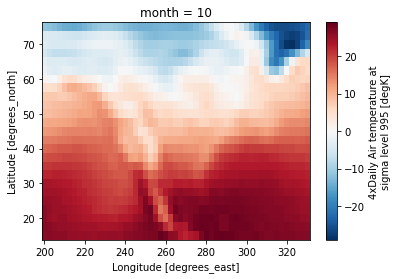

In [92]:
ds_clim.air.sel(month=10).plot()